## data preparing 

In [1]:
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

# data path
sic_path = "Data/SIC_1979_2020_Jan_May_96.npy" # the data is from 1979-2019 (12 months/year) and the fisrt 5 months of 2020
sit_pio_path = "Data/SIT_1979_2020_Jan_May_96.npy"

# land mask
mask = np.load("Data/mask_96.npy")

close_n = 6 #input length
y_length = 6 #output length

# month per year
biweek_per_year = 12

# load sic and sit data
total_sic = np.load(sic_path) 
total_sit = np.load(sit_pio_path) # sit has been scaled to 0-1 

# load climate mean data
total_sic_clim = np.load("Data/SIC_climate_mean_96.npy")

# calculate anomaly
total_sic_anom = total_sic - total_sic_clim

In [2]:
print(total_sic.shape)
print(total_sit.shape)
print(total_sic_clim.shape)

(497, 96, 96)
(497, 96, 96)
(497, 96, 96)


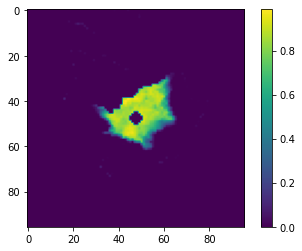

In [3]:
# show an example of sic
import matplotlib.pyplot as plt
# show index
flag_idx = -9
plt.imshow(total_sic[flag_idx,:,:])
plt.colorbar()

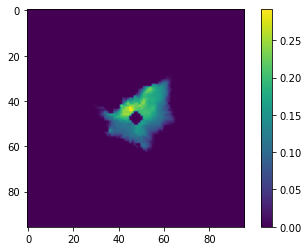

In [4]:
# show an example of sit
import matplotlib.pyplot as plt
plt.imshow(total_sit[flag_idx,:,:])
plt.colorbar()

In [5]:
# construct training set
x_inputs = []
y_ground = []

start_week = 0
for i in range(start_week, total_sic.shape[0]-y_length-close_n+1):
    
    cur_x_close = total_sic[i: i + close_n, :, :]
    cur_y       = total_sic[i + close_n: i + close_n + y_length, :, :]
     
    cur_x_close_sit = total_sit[i: i + close_n, :, :]
    cur_x_sic_clim = total_sic_clim[i: i + close_n, :, :]
    cur_y_sic_clim = total_sic_clim[i + close_n: i + close_n + y_length, :, :]
    cur_x_sic_anom = total_sic_anom[i: i + close_n, :, :]

    # merge the sit, sic, anomaly and climate mean data 
    cur_x_close_sit_cut = cur_x_close_sit[-3:]
    cur_x_sic_anom_cut =  cur_x_sic_anom[-3:]
    cur_x_close_merge = np.concatenate((cur_x_close_sit_cut, cur_x_close, cur_x_sic_anom_cut, cur_y_sic_clim), axis = 0)
    x_inputs.append(cur_x_close_merge)
    
    
    y_sic_sit = cur_y
    y_ground.append(y_sic_sit)
    
x_inputs = np.array(x_inputs)
y_ground = np.array(y_ground)

x_clo_sic = x_inputs
y_sic = y_ground

In [6]:
print(x_clo_sic.shape)
print(y_sic.shape)

(486, 18, 96, 96)
(486, 6, 96, 96)


In [7]:
# reshape the prediction results to: target(y axis), lead months(x axis), for testing data
def reshape_based_leadtime (y_matrix):
    #sample numbers
    lead_time = y_matrix.shape[3]
    all_samples = []
    for row in range(y_matrix.shape[0] - lead_time+1):
        
        cur_target = []
        for j in reversed(range(lead_time)):#leadtime 5
            cur_target.append(y_matrix[row+j,:,:,lead_time-(j+1)])
            
        cur_target = np.array(cur_target)
        all_samples.append(cur_target) 
              
    all_samples = np.array(all_samples)    
    return all_samples

In [8]:
# swap axes for model training

x_clo_sic = x_clo_sic.swapaxes(1, 3)
y_sic = y_sic.swapaxes(1, 3)

x_clo_sic = x_clo_sic.swapaxes(1, 2)
y_sic = y_sic.swapaxes(1, 2)

In [9]:
print(x_clo_sic.shape)
print(y_sic.shape)

(486, 96, 96, 18)
(486, 96, 96, 6)


In [10]:
# set batchsize，and make mask for the final output
batch_size = 8
mask_unit_0 = np.expand_dims(mask, axis=-1)
mask_unit_4dim = mask_unit_0
mask_unit_4dim = np.expand_dims(mask_unit_4dim, axis=0)

## model construction

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
import os
from model_utils._model_swin_unet_2d import swin_unet_2d

# config
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
config = tf.compat.v1.ConfigProto(allow_soft_placement=False)
config.gpu_options.allow_growth=True   
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

####IIEE inverse
def IIEE_r(y_true, y_pred, eps=1e-6):

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean( (intersection + eps) / (union + eps), axis=0)

def IIEE_loss(y_true, y_pred):
    return 1 - IIEE_r(y_true, y_pred)

# mse and mae
def mse_mae(y_true, y_pred):
    
    MSE_P = K.square(y_pred - y_true)
    F_MSE = K.mean(MSE_P, axis=0)
    
    MAE_P = K.abs(y_pred - y_true)
    F_MAE = K.mean(MAE_P, axis=0)

    return F_MSE + F_MAE

# mse and NIIEE loss
def mse_iou(y_true, y_pred):
    mse_loss = mse_mae(y_true, y_pred)
    iiee_loss = IIEE_loss(y_true, y_pred)
    
    return mse_loss + iiee_loss*0.01

# paramters of array shape
INPUT_X = x_clo_sic.shape[-3]
INPUT_Y = x_clo_sic.shape[-2]
INPUT_Chanel_Close = x_clo_sic.shape[-1]
OUTPUT_Channel = y_sic.shape[-1]

# hyper parameters for swin-unet
filter_num = 128
depth_num = 4
stack_num_d = 1
stack_num_u = 1

num_heads_s = [2, 2, 2, 2]
window_size_s = [4, 4, 4, 2]
num_mlp_s = 256
Data_Format = "channels_last"

# name_flag for labelling the model
name_flage = str(filter_num)+"_"+str(depth_num)+"_sn"+str(stack_num_d)+"_w442_nh2_mn256_"

# construct the model
def SICNet_Season_Forecast():
    
    # input for the model
    input_close = Input((INPUT_X,INPUT_Y,INPUT_Chanel_Close))
    
    # swin_unet model
    # swin_unet model
    output_swin = swin_unet_2d(input_close, filter_num_begin=filter_num, n_labels=OUTPUT_Channel, depth=depth_num, stack_num_down=stack_num_d, stack_num_up=stack_num_u, 
                            patch_size=(2, 2), num_heads=num_heads_s, window_size=window_size_s, num_mlp=num_mlp_s, 
                            output_activation='', shift_window=True, name='swin_unet')
    
    
    output_final = Activation('sigmoid')(output_swin)
    
    # land mask
    output_final = mask_unit_4dim * output_final 
    
    model = Model(inputs=[input_close], outputs=output_final)
    
    return model

our_model = SICNet_Season_Forecast()
our_model.compile(optimizer = Adam(lr=0.0001), loss=mse_iou, metrics = ['mae'] )
our_model.summary()



2024-11-27 02:07:26.174940: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-11-27 02:07:27.484497: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 02:07:27.494009: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-11-27 02:07:27.526229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2024-11-27 02:07:27.526320: I tensorflow/stream_executor/platform/default/dso

2024-11-27 02:07:29.322562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2024-11-27 02:07:29.339144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2024-11-27 02:07:29.345436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2024-11-27 02:07:29.362784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2024-11-27 02:07:29.362937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-11-27 02:07:29.362976: I tensorflow/core/com

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 18)] 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 2304, 72)     0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 2304, 128)    304256      patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 2304, 128)    13

/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## model training and testing

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

PATH = "/Result/Model/"

# earlystopping and reduce the learning rate
earlystopping = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)
training_history_full_file_name = PATH + "Train_history.h5" # 

# training and testing by leave-one-year-out strategy, 2000-2019
steps = 1
for test_year in range (22, -1, -1*steps):
    
    lead_time_steps = y_length - 1 
    test_flag = (steps+test_year) * biweek_per_year + lead_time_steps 
    smaples_pery = biweek_per_year*steps+lead_time_steps #17 there are 17 samples per year, covering the lead months of 1-6 for the 12 target months
    
    # construct training set
    x_clo_sic_train = x_clo_sic[0:-test_flag, :, :, :]
    y_sic_train = y_sic[0:-test_flag, :, :, :]
    
    # remaining test set if the testing year is the last year
    if (test_year == 0):
        x_clo_sic_test = x_clo_sic[-test_flag:, :, :, :] 
        y_sic_test = y_sic[-test_flag:, :, :, :]
        
    # if the testing year is not the last year 
    else:
        x_clo_sic_test = x_clo_sic[-test_flag:-test_flag+smaples_pery, :, :, :] # 
        y_sic_test = y_sic[-test_flag:-test_flag+smaples_pery:, :, :, :]
        
        x_end_clo_sic_test = x_clo_sic[-test_flag+smaples_pery:, :, :, :]
        y_end_sic_test = y_sic[-test_flag+smaples_pery:, :, :, :]
        
        x_clo_sic_train = np.concatenate((x_clo_sic_train, x_end_clo_sic_test), axis = 0)
        y_sic_train = np.concatenate((y_sic_train, y_end_sic_test), axis = 0)

    # training 3 instances for each config and calcualte the mean value
    for j in range(1,4):
        model_saved_full_file_name = PATH + "SwinUNet_202310_"+name_flage+str(2022-test_year)+"_"+str(j)+".h5"# 
        our_model_1 = SICNet_Season_Forecast()
        our_model_1.compile(optimizer = Adam(lr=0.0001), loss=mse_iou, metrics = ['mae'] )
        checkpoint= ModelCheckpoint(model_saved_full_file_name, monitor='val_loss', verbose=1,
                            save_best_only=True, mode='min',
                            save_weights_only=False,period=0)
        
        # model training        
        model_train_history = our_model_1.fit(x = x_clo_sic_train, y =  y_sic_train, shuffle=True, 
                                    epochs=300, batch_size = batch_size, 
                                    validation_split=0.2, verbose=1,
                                    callbacks=[checkpoint, earlystopping, reducecall])
    

2024-11-26 06:51:02.969060: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-11-26 06:51:02.969728: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz


Epoch 1/300


2024-11-26 06:51:08.892105: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-11-26 06:51:09.763907: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-11-26 06:51:09.792433: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-11-26 06:51:10.509172: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2024-11-26 06:51:11.394065: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-26 06:51:11.394180: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2024-11-26 06:51:11.397871: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-26 06:51:11.398088: W tensorflow/stream_executor/gpu/redzo

47/47 [==============================] - 14s 108ms/step - loss: 0.0903 - mae: 0.0583 - val_loss: 0.0445 - val_mae: 0.0292

Epoch 00001: val_loss improved from inf to 0.04454, saving model to /Result/Model/SwinUNet_202310_128_3_sn1_w442_nh2_mn256_2000_1.h5
Epoch 2/300
47/47 [==============================] - 3s 73ms/step - loss: 0.0357 - mae: 0.0243 - val_loss: 0.0310 - val_mae: 0.0214

Epoch 00002: val_loss improved from 0.04454 to 0.03104, saving model to /Result/Model/SwinUNet_202310_128_3_sn1_w442_nh2_mn256_2000_1.h5
Epoch 3/300
 8/47 [====>.........................] - ETA: 2s - loss: 0.0307 - mae: 0.0212